In [1]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

lambert_crs = ccrs.LambertConformal(
    central_longitude=-107.0,
    central_latitude=50.0,
    standard_parallels=[50.0, 50.0],
    false_easting=5632642.22547,
    false_northing=4612545.65137
)

In [2]:
data = pd.read_csv('~/Desktop/columbia/capstone/fire-regimes/data/merged_data.csv')

df_dedup = data.groupby(['time', 'x', 'y', 'level'], as_index=False).mean()
df_pivoted = df_dedup.set_index(['time', 'y', 'x', 'level']).unstack('level')

df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]

# Reset the index to bring 'time', 'y', 'x' back as columns
df = df_pivoted.reset_index().drop(columns=['time','y','x'])
X = df[~np.isnan(df).any(axis=1)]
X = normalize(X,axis=0)

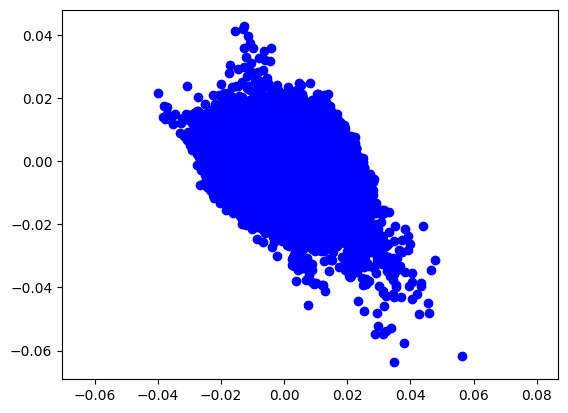

In [7]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Y = pca.transform(X)

plt.scatter(Y[:,0], Y[:,1], color='blue', marker='o')
plt.axis('equal')
plt.show()

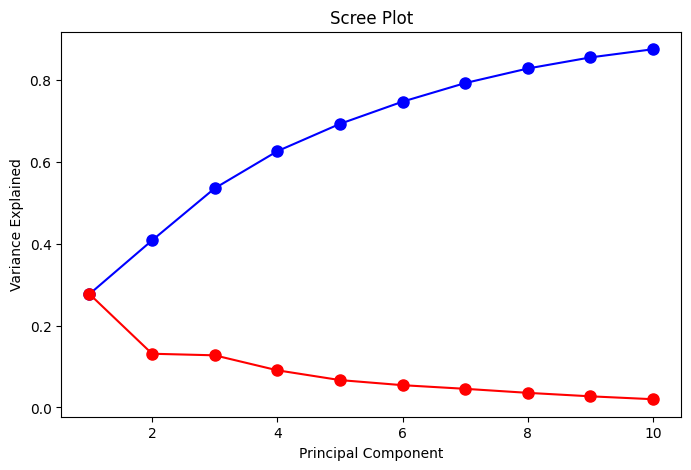

In [12]:
full_pca = decomposition.PCA(n_components=10)
full_pca.fit(X)

explained_variance = full_pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), 'o-', markersize=8, color='blue', label='Cumulative Explained Variance')
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', markersize=8, color='red', label='Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Read in GlobFire data:

In [9]:
main = gpd.read_file('~/Desktop/columbia/capstone/weatherregimes/full_globfire/full_globfire.shp')
main = pd.concat([main,main.bounds], axis=1)

In [2]:
directory_path = '../weatherregimes/assets/all'
file_list = [os.path.join(directory_path, f) for f in os.listdir(directory_path)]

datasets = [xr.open_dataset(file) for file in file_list]

merged_dataset = xr.merge(datasets)

Here's how we put the data on the levels we care about:

In [42]:
full = merged_dataset.stack(location=('y', 'x', 'time'))
full = full.to_stacked_array("var-lvl",sample_dims=["location"])
coordinates = full.coords

X = full[~np.isnan(full).any(axis=1)]

Playing with Dimension Reduction

In [46]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(X.values)  # Use the raw values from the stacked array

# Reconstruct as an xarray.DataArray with the original coordinates
pca_da = xr.DataArray(
    pca_result, 
    coords={'location': X['location'], 'component': [1]}, 
    dims=['location', 'component']
)

In [ ]:
first_pc_unstacked = pca_da.unstack('location')

# Now plot the first principal component using x, y coordinates as a map
plt.figure(figsize=(8, 6))
first_pc_unstacked.plot(cmap='viridis')
plt.title('First Principal Component by X, Y Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
first_pc_unstacked.plot(ax=ax, cmap='viridis',transform=None)
ax.coastlines(resolution='50m')
plt.title("North America by Value of 1st Principle Component")
plt.show()

In [ ]:
full_pca = decomposition.PCA()
full_pca.fit(X)

explained_variance = full_pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', markersize=8, color='blue', label='Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
pca_10 = decomposition.PCA(n_components=10)
pca_10.fit(X)
Z = pca_10.transform(X)
tsne_result = TSNE(n_components=2, random_state=1).fit_transform(Z)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=5, color='blue')
plt.show()

In [7]:
full = merged_dataset.stack(pixel=('y', 'x', 'time')).to_stacked_array("var-lvl",sample_dims=["pixel"])
coordinates = full.coords

X = full[~np.isnan(full).any(axis=1)]
X = normalize(X,axis=0)

In [10]:
print(pca.explained_variance_ratio_)

[0.27684639 0.13106491]


In [3]:
pca = decomposition.PCA(n_components=10)
pca.fit(X)
Y = pca.transform(X)

In [4]:
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(Y)

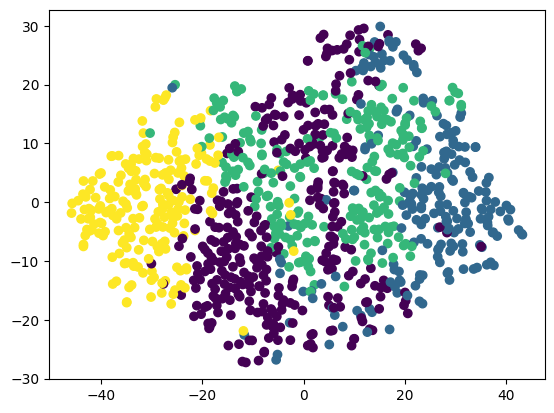

<Figure size 800x600 with 0 Axes>

In [8]:
random_indices = np.random.choice(Y.shape[0], size=1000, replace=False)

# Use the random indices to sample rows
X_sample = Y[random_indices]


tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X_sample)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels[random_indices], cmap='viridis')

plt.figure(figsize=(8, 6))
plt.show()

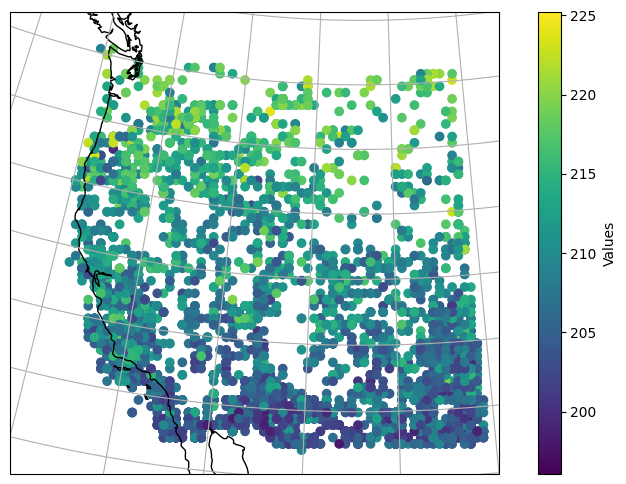

In [28]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
data = df_pivoted.reset_index().drop_duplicates('time')[['x','y','100.0-air']]

x_coords = data['x'].values
y_coords = data['y'].values
values = data['100.0-air'].values

scatter = ax.scatter(x_coords, y_coords, c=values, cmap='viridis', transform=None)

# Add a color bar to show the scale of values
plt.colorbar(scatter, ax=ax, orientation='vertical', label='Air temperature at 100.0 hPa')

# Show the plot
ax.set_extent([235, 260, 30, 50], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=False)

plt.show()